In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [7]:
file_path = '/content/fraudTrain.csv'
d = pd.read_csv(file_path)

In [8]:
print(d.head())
print(d.info())
print(d.describe())

   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Greens Suite 393  ...  48

In [9]:
print(d.isnull().sum())

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 1
amt                      1
first                    1
last                     1
gender                   1
street                   1
city                     1
state                    1
zip                      1
lat                      1
long                     1
city_pop                 1
job                      1
dob                      1
trans_num                1
unix_time                1
merch_lat                1
merch_long               1
is_fraud                 1
dtype: int64


In [10]:
d.dropna(inplace=True)

In [11]:
datetime_columns = []

In [12]:
for column in d.columns:
    if d[column].dtype == 'object':
        try:
            d[column] = pd.to_datetime(d[column])
            datetime_columns.append(column)
        except ValueError:
            pass

<ipython-input-12-d63a496b5efe>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d[column] = pd.to_datetime(d[column])
<ipython-input-12-d63a496b5efe>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d[column] = pd.to_datetime(d[column])
<ipython-input-12-d63a496b5efe>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d[column] = pd.to_datetime(d[column])
<ipython-input-12-d63a496b5efe>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d[

In [13]:
for column in datetime_columns:
    d[column] = d[column].astype('int64') // 10**9

In [14]:
label_encoders = {}
for column in d.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    d[column] = label_encoders[column].fit_transform(d[column])

In [15]:
X = d.drop(columns=['is_fraud'])
y = d['is_fraud']

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [18]:
def evaluate_and_plot(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    print(f"{model_name} Model")
    print(classification_report(y_test, predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))
    print(f"ROC AUC: {roc_auc_score(y_test, predictions)}\n")

    # Plot ROC Curve
    try:
        pred_probabilities = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        print(f"{model_name} does not support predict_proba.")
        return
    fpr, tpr, _ = roc_curve(y_test, pred_probabilities)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, pred_probabilities):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

Logistic Regression Model
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     28906
         1.0       0.05      0.01      0.01       270

    accuracy                           0.99     29176
   macro avg       0.52      0.50      0.50     29176
weighted avg       0.98      0.99      0.99     29176

Confusion Matrix:
[[28867    39]
 [  268     2]]
ROC AUC: 0.5030291032747269



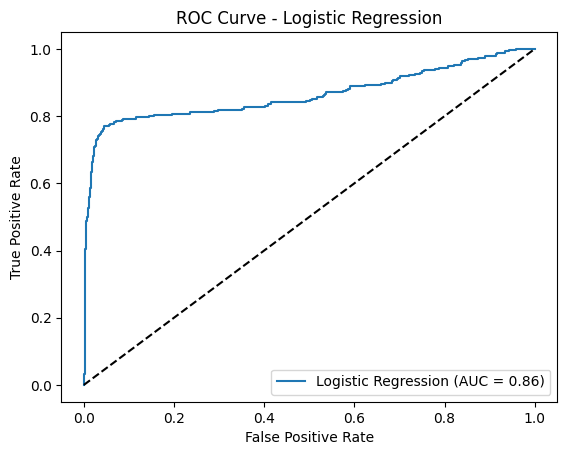

In [19]:
log_reg = LogisticRegression()
evaluate_and_plot(log_reg, "Logistic Regression", X_train, y_train, X_test, y_test)

Random Forest Model
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     28906
         1.0       0.97      0.73      0.83       270

    accuracy                           1.00     29176
   macro avg       0.98      0.86      0.92     29176
weighted avg       1.00      1.00      1.00     29176

Confusion Matrix:
[[28900     6]
 [   73   197]]
ROC AUC: 0.8647110301334338



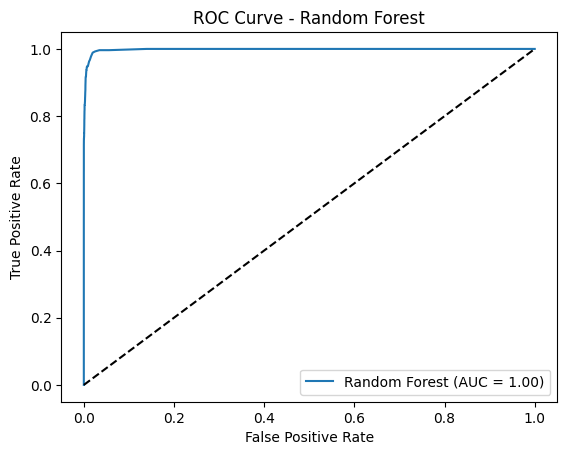

In [20]:
rf = RandomForestClassifier()
evaluate_and_plot(rf, "Random Forest", X_train, y_train, X_test, y_test)

Gradient Boosting Model
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     28906
         1.0       0.81      0.71      0.76       270

    accuracy                           1.00     29176
   macro avg       0.91      0.85      0.88     29176
weighted avg       1.00      1.00      1.00     29176

Confusion Matrix:
[[28862    44]
 [   79   191]]
ROC AUC: 0.8529426160402428



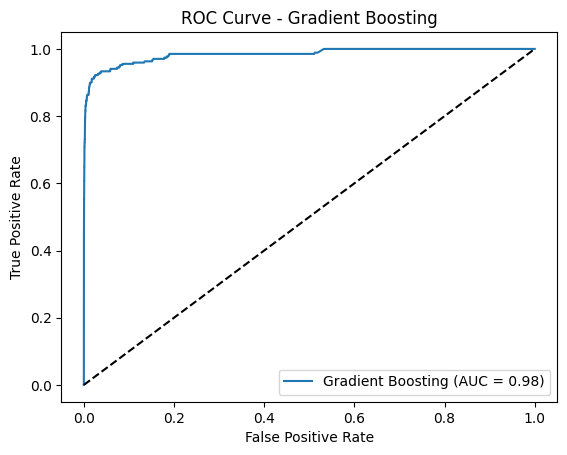

In [21]:
gb = GradientBoostingClassifier()
evaluate_and_plot(gb, "Gradient Boosting", X_train, y_train, X_test, y_test)